In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Dataset imports:
from data.moleDataset import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math

In [33]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [34]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print(f'Using: {torch.cuda.get_device_name(0)}')
print(f'Current device: {device}')

Using: NVIDIA GeForce GTX 1060 6GB
Current device: cuda


# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [35]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [36]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.
image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std)])

# This transform is the same as the above one but it does not convert to Tensor
# So the returned image from the dataset can be visualized easier.
image_preprocessing_test = transforms.Compose([
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

# Defining the dataset:

In [37]:
# Creating the dataset instance:
test_dataset = MoleDataset(transform=image_preprocessing)

### The dataset class distribution:

In [38]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

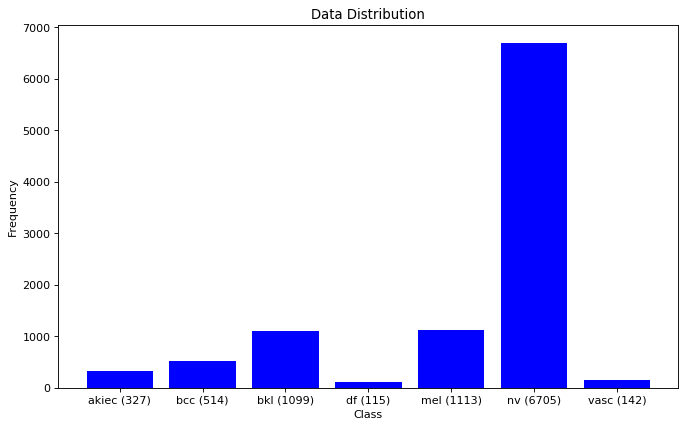

In [39]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [40]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [41]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32)

### Creating the model:

In [44]:
model_overfit = SkinCancerModel()

### The hyperparameters, the loss function and the optimizer:

In [45]:
learning_rate = 1e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_overfit.parameters(), lr=learning_rate, momentum=momentum)

In [46]:
epochs = 60

### Overfitting the model:

In [47]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

  2%|▏         | 1/60 [00:16<16:11, 16.47s/it]

Epoch: 0 | Train_acc: 17.00% | Val_acc: 17.00% | Loss: 10.26 | Runtime: 16.47 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

  3%|▎         | 2/60 [00:32<15:45, 16.31s/it]

Epoch: 1 | Train_acc: 12.00% | Val_acc: 12.00% | Loss: 8.09 | Runtime: 16.19 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

  5%|▌         | 3/60 [00:48<15:27, 16.27s/it]

Epoch: 2 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 6.17 | Runtime: 16.22 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

  7%|▋         | 4/60 [01:05<15:24, 16.51s/it]

Epoch: 3 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 4.73 | Runtime: 16.89 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

  8%|▊         | 5/60 [01:21<15:01, 16.38s/it]

Epoch: 4 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 5.53 | Runtime: 16.16 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 10%|█         | 6/60 [01:38<14:42, 16.35s/it]

Epoch: 5 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 3.57 | Runtime: 16.27 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 12%|█▏        | 7/60 [01:54<14:28, 16.38s/it]

Epoch: 6 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 4.58 | Runtime: 16.46 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 13%|█▎        | 8/60 [02:10<14:09, 16.33s/it]

Epoch: 7 | Train_acc: 69.00% | Val_acc: 69.00% | Loss: 4.03 | Runtime: 16.22 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 15%|█▌        | 9/60 [02:27<13:50, 16.28s/it]

Epoch: 8 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 3.02 | Runtime: 16.16 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 17%|█▋        | 10/60 [02:43<13:33, 16.27s/it]

Epoch: 9 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 2.94 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 18%|█▊        | 11/60 [02:59<13:15, 16.24s/it]

Epoch: 10 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 2.93 | Runtime: 16.17 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 20%|██        | 12/60 [03:15<12:58, 16.22s/it]

Epoch: 11 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 3.67 | Runtime: 16.17 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 22%|██▏       | 13/60 [03:31<12:43, 16.25s/it]

Epoch: 12 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 2.78 | Runtime: 16.34 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 23%|██▎       | 14/60 [03:48<12:27, 16.24s/it]

Epoch: 13 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 3.41 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 25%|██▌       | 15/60 [04:04<12:12, 16.27s/it]

Epoch: 14 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 2.56 | Runtime: 16.35 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 27%|██▋       | 16/60 [04:20<11:56, 16.29s/it]

Epoch: 15 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.84 | Runtime: 16.33 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 28%|██▊       | 17/60 [04:37<11:39, 16.26s/it]

Epoch: 16 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 3.11 | Runtime: 16.18 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 30%|███       | 18/60 [04:53<11:21, 16.24s/it]

Epoch: 17 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 2.66 | Runtime: 16.18 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 32%|███▏      | 19/60 [05:09<11:07, 16.28s/it]

Epoch: 18 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.42 | Runtime: 16.38 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 33%|███▎      | 20/60 [05:25<10:50, 16.27s/it]

Epoch: 19 | Train_acc: 79.00% | Val_acc: 79.00% | Loss: 2.94 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 35%|███▌      | 21/60 [05:42<10:34, 16.27s/it]

Epoch: 20 | Train_acc: 80.00% | Val_acc: 80.00% | Loss: 2.21 | Runtime: 16.27 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 37%|███▋      | 22/60 [05:58<10:19, 16.31s/it]

Epoch: 21 | Train_acc: 82.00% | Val_acc: 82.00% | Loss: 2.27 | Runtime: 16.40 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 38%|███▊      | 23/60 [06:15<10:08, 16.44s/it]

Epoch: 22 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.31 | Runtime: 16.75 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 40%|████      | 24/60 [06:31<09:49, 16.37s/it]

Epoch: 23 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 2.24 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 42%|████▏     | 25/60 [06:47<09:32, 16.37s/it]

Epoch: 24 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 2.19 | Runtime: 16.36 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 43%|████▎     | 26/60 [07:04<09:15, 16.34s/it]

Epoch: 25 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.01 | Runtime: 16.28 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 45%|████▌     | 27/60 [07:20<08:58, 16.31s/it]

Epoch: 26 | Train_acc: 79.00% | Val_acc: 79.00% | Loss: 1.81 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 47%|████▋     | 28/60 [07:36<08:41, 16.29s/it]

Epoch: 27 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 2.17 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 48%|████▊     | 29/60 [07:52<08:24, 16.28s/it]

Epoch: 28 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.91 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 50%|█████     | 30/60 [08:09<08:09, 16.30s/it]

Epoch: 29 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.67 | Runtime: 16.36 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 52%|█████▏    | 31/60 [08:25<07:52, 16.28s/it]

Epoch: 30 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 2.08 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 53%|█████▎    | 32/60 [08:41<07:35, 16.27s/it]

Epoch: 31 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.53 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 55%|█████▌    | 33/60 [08:57<07:18, 16.25s/it]

Epoch: 32 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.64 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 57%|█████▋    | 34/60 [09:14<07:03, 16.30s/it]

Epoch: 33 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.57 | Runtime: 16.41 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 58%|█████▊    | 35/60 [09:30<06:46, 16.27s/it]

Epoch: 34 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.62 | Runtime: 16.19 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 60%|██████    | 36/60 [09:46<06:31, 16.29s/it]

Epoch: 35 | Train_acc: 92.00% | Val_acc: 92.00% | Loss: 1.40 | Runtime: 16.36 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

 62%|██████▏   | 37/60 [10:03<06:16, 16.39s/it]

Epoch: 36 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.81 | Runtime: 16.60 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 63%|██████▎   | 38/60 [10:19<05:59, 16.35s/it]

Epoch: 37 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.38 | Runtime: 16.26 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

 65%|██████▌   | 39/60 [10:36<05:44, 16.38s/it]

Epoch: 38 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.33 | Runtime: 16.47 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

 67%|██████▋   | 40/60 [10:52<05:27, 16.36s/it]

Epoch: 39 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.18 | Runtime: 16.31 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 68%|██████▊   | 41/60 [11:08<05:10, 16.33s/it]

Epoch: 40 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.44 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 70%|███████   | 42/60 [11:24<04:53, 16.29s/it]

Epoch: 41 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.68 | Runtime: 16.20 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 72%|███████▏  | 43/60 [11:41<04:37, 16.34s/it]

Epoch: 42 | Train_acc: 94.00% | Val_acc: 94.00% | Loss: 1.12 | Runtime: 16.47 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 73%|███████▎  | 44/60 [11:57<04:21, 16.34s/it]

Epoch: 43 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.11 | Runtime: 16.33 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 75%|███████▌  | 45/60 [12:13<04:04, 16.31s/it]

Epoch: 44 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.33 | Runtime: 16.23 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 77%|███████▋  | 46/60 [12:30<03:48, 16.30s/it]

Epoch: 45 | Train_acc: 92.00% | Val_acc: 92.00% | Loss: 1.14 | Runtime: 16.29 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 78%|███████▊  | 47/60 [12:46<03:31, 16.29s/it]

Epoch: 46 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.07 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 80%|████████  | 48/60 [13:02<03:15, 16.29s/it]

Epoch: 47 | Train_acc: 94.00% | Val_acc: 94.00% | Loss: 1.03 | Runtime: 16.30 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 82%|████████▏ | 49/60 [13:19<02:59, 16.32s/it]

Epoch: 48 | Train_acc: 94.00% | Val_acc: 94.00% | Loss: 1.13 | Runtime: 16.38 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 83%|████████▎ | 50/60 [13:35<02:43, 16.30s/it]

Epoch: 49 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.20 | Runtime: 16.26 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 85%|████████▌ | 51/60 [13:51<02:26, 16.33s/it]

Epoch: 50 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.34 | Runtime: 16.39 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 87%|████████▋ | 52/60 [14:08<02:10, 16.32s/it]

Epoch: 51 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 0.76 | Runtime: 16.30 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 88%|████████▊ | 53/60 [14:24<01:54, 16.30s/it]

Epoch: 52 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.11 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 90%|█████████ | 54/60 [14:40<01:37, 16.26s/it]

Epoch: 53 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.09 | Runtime: 16.16 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 92%|█████████▏| 55/60 [14:56<01:21, 16.31s/it]

Epoch: 54 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 1.12 | Runtime: 16.42 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 93%|█████████▎| 56/60 [15:13<01:05, 16.27s/it]

Epoch: 55 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 0.74 | Runtime: 16.19 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 95%|█████████▌| 57/60 [15:29<00:48, 16.27s/it]

Epoch: 56 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 0.92 | Runtime: 16.27 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

 97%|█████████▋| 58/60 [15:45<00:32, 16.36s/it]

Epoch: 57 | Train_acc: 97.00% | Val_acc: 97.00% | Loss: 0.56 | Runtime: 16.56 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 98%|█████████▊| 59/60 [16:02<00:16, 16.31s/it]

Epoch: 58 | Train_acc: 97.00% | Val_acc: 97.00% | Loss: 0.62 | Runtime: 16.20 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

100%|██████████| 60/60 [16:18<00:00, 16.31s/it]

Epoch: 59 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 0.75 | Runtime: 16.25 seconds


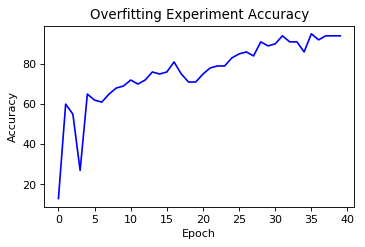

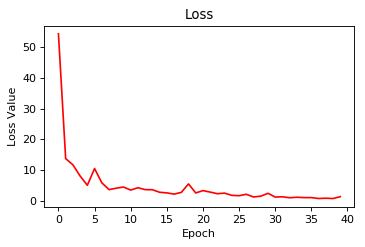

In [31]:
figure(figsize=(5, 3), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Setting up the actual model:

### Defining the Dataset object:

In [21]:
dataset = MoleDataset(transform=image_preprocessing)

### Splitting the dataset into train, validation, and test sets:

In [22]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Defining the sizes of the splits:

# 1) The train set size:
train_size = math.ceil(train_proportion * len(dataset))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(dataset))

# 3) The test set size:
test_size = math.floor(test_proportion * len(dataset))

# Defining the train, validation, and test sets:
train_set, validation_set = random_split(dataset, [train_size, validation_size + test_size])
test_set, validation_set = random_split(validation_set, [test_size, validation_size])

print(f"Train set size: {train_size} | Validation set size: {validation_size} | Test set size {test_size}")

Train set size: 8012 | Validation set size: 1002 | Test set size 1001


### Creating the DataLoader objects:

In [36]:
train_batch_size, validation_batch_size, test_batch_size = 8, 8, 16

# Setting the num_workers to the number of cores on this machine.
num_workers = 4

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers)
test_loader = DataLoader(test_set, shuffle=True, batch_size=test_batch_size, num_workers=num_workers)

### Creating the model:

In [37]:
model = SkinCancerModel()

### Defining the optimizer, criterion, and hyperparameters:

In [38]:
learning_rate = 1e-3 # 1e-3 in the previous trial.

# Getting the classes weights:
loss_weights = torch.tensor(dataset.class_weights(), dtype=torch.float)

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Defining the learning rate schedular:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # None in the previous trial.

# Defining the weighted loss function:
criterion = nn.CrossEntropyLoss(weight=loss_weights)
criterion = criterion.to(device=device)

### Defining the number of epochs:

In [39]:
epochs = 10 # 10 in the previous trial.

# Training the model

In [40]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating epoch...


 10%|█         | 1/10 [01:47<16:03, 107.07s/it]

Learning rate: 0.008
Epoch: 0 | Train_acc: 42.36% | Val_acc: 42.02% | Loss: 2644.31 | Runtime: 107.07 seconds
Evaluating epoch...


 20%|██        | 2/10 [03:32<14:06, 105.83s/it]

Learning rate: 0.008
Epoch: 1 | Train_acc: 68.50% | Val_acc: 65.17% | Loss: 1152.45 | Runtime: 104.95 seconds
Evaluating epoch...


 30%|███       | 3/10 [05:18<12:21, 105.90s/it]

Learning rate: 0.008
Epoch: 2 | Train_acc: 69.03% | Val_acc: 65.97% | Loss: 1065.94 | Runtime: 106.00 seconds
Evaluating epoch...


 40%|████      | 4/10 [07:02<10:33, 105.53s/it]

Learning rate: 0.008
Epoch: 3 | Train_acc: 73.33% | Val_acc: 69.36% | Loss: 1019.84 | Runtime: 104.96 seconds
Evaluating epoch...


 50%|█████     | 5/10 [08:47<08:46, 105.30s/it]

Learning rate: 0.008
Epoch: 4 | Train_acc: 72.29% | Val_acc: 68.96% | Loss: 981.28 | Runtime: 104.89 seconds
Evaluating epoch...


 60%|██████    | 6/10 [10:34<07:02, 105.58s/it]

Learning rate: 0.0008
Epoch: 5 | Train_acc: 73.14% | Val_acc: 70.26% | Loss: 905.94 | Runtime: 106.13 seconds
Evaluating epoch...


 70%|███████   | 7/10 [12:19<05:16, 105.39s/it]

Learning rate: 0.0008
Epoch: 6 | Train_acc: 71.74% | Val_acc: 68.46% | Loss: 888.51 | Runtime: 104.99 seconds
Evaluating epoch...


 80%|████████  | 8/10 [14:03<03:30, 105.11s/it]

Learning rate: 0.0008
Epoch: 7 | Train_acc: 71.70% | Val_acc: 68.36% | Loss: 884.69 | Runtime: 104.49 seconds
Evaluating epoch...


 90%|█████████ | 9/10 [15:47<01:44, 104.83s/it]

Learning rate: 0.0008
Epoch: 8 | Train_acc: 73.53% | Val_acc: 70.46% | Loss: 876.15 | Runtime: 104.22 seconds
Evaluating epoch...


100%|██████████| 10/10 [17:31<00:00, 105.12s/it]

Learning rate: 0.0008
Epoch: 9 | Train_acc: 73.24% | Val_acc: 69.66% | Loss: 875.01 | Runtime: 103.50 seconds


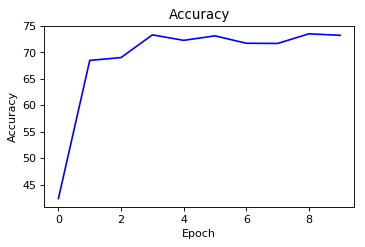

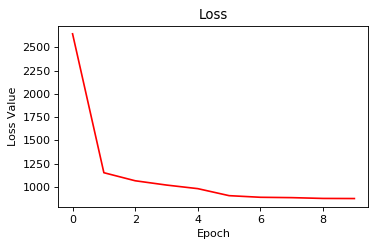

In [41]:
figure(figsize=(5, 3), dpi=80)
plt.title('Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Evaluating the model with the test set:

In [42]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


In [43]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 70.63%
